In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[Tweakers ransack supermarket, coming soon to Fox](https://www.reddit.com/r/aivideo/comments/1e8gu12/tweakers_ransack_supermarket/)

___

[A reddit discussion summarizer -](https://www.reddit.com/r/ChatGPT/comments/1e844z8/glance_i_created_an_ai_to_summarize_reddit_for_you/)

___

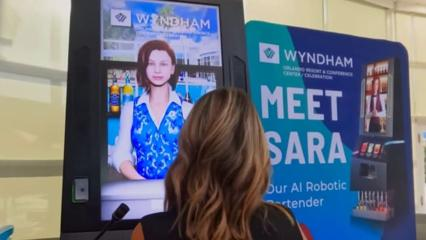

[AI bartender kiosk can pour 120 drinks an hour. Should have had this replicator in the old Las Vegas Hilton Star Trek Experience. (demo around 1:00 in)](https://www.clickorlando.com/food/2024/07/20/screen-shots-anyone-ai-bartender-debuted-in-hotel-near-disney-world/) - WKMG

___

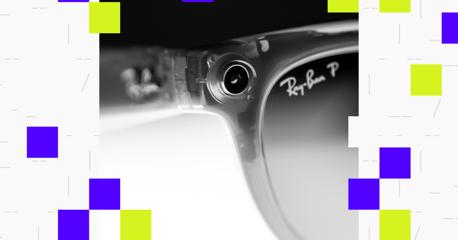

[Google has also approached Luxottica, after previously partnering with them for Google Glass.](https://www.theverge.com/2024/7/19/24202244/google-meta-ray-ban-essilorluxottica-partnership) - The Verge

___

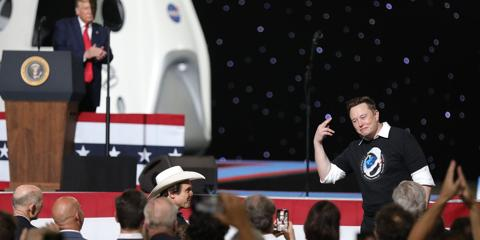

[Musk being a POS, just another Sunday in his deranged mind](https://www.rawstory.com/secret-service-elon-musk-trump-ai-biden/) - Raw Story - Celebrating 20 Years of Independent Journalism

___

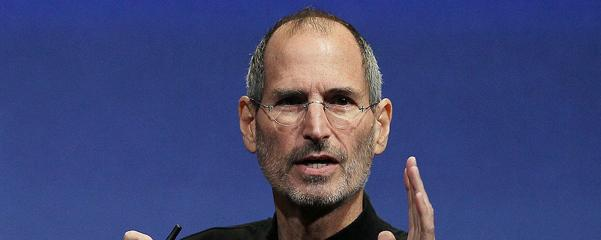

[Steve Jobs in 1985, talking about capturing the next Aristotle as an AI chatbot.](https://deadline.com/2024/07/steve-jobs-predicted-chatgpt-tools-decades-before-1236016736/) - Deadline

___

[A doctor and former FDA commissioner puts LLMs to the test on medical questions, and they perform well. Doesn't say how they made sure none of them have already seen the  questions in training. 98% correct seems suspicious. nbc.com/2024/07/18/op-ed-how-well-can-ai-chatbots-mimic-doctors.html](https://nbc.com/2024/07/18/op-ed-how-well-can-ai-chatbots-mimic-doctors.html)

___

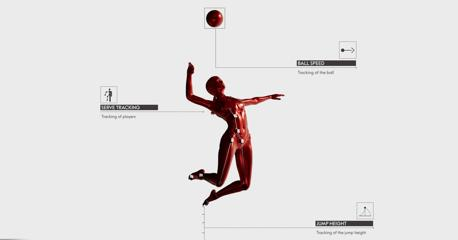

[High tech sensing and modeling and dataviz at the Paris Olympics.](https://www.wired.com/story/omegas-ai-will-map-how-olympic-athletes-win/) - WIRED

___

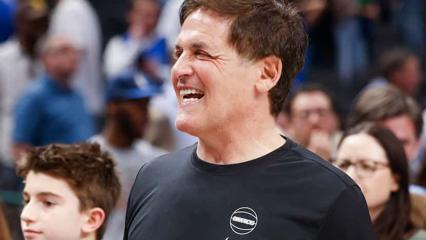

[Mark Cuban says algorithms and AI could swing the election.](https://www.dallasnews.com/opinion/editorials/2024/07/21/mark-cubans-ai-election-prediction-rings-true-and-thats-terrifying/) - Dallas News

___

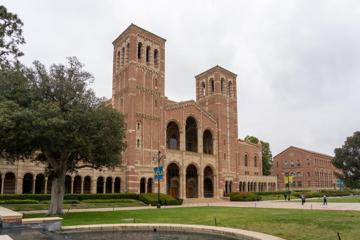

[AI is gains acceptance to help treat prostate cancer, outperforming doctors in some diagnostics.](https://nypost.com/2024/07/20/lifestyle/ai-detects-cancer-with-17-more-accuracy-than-doctors-ucla-study/) - New York Post

___

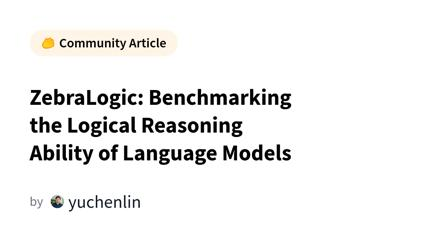

[Blog post -](https://huggingface.co/blog/yuchenlin/zebra-logic)

___

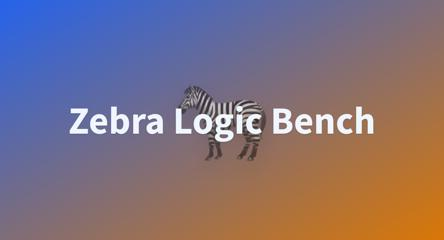

[Allen Institute for AI is working on better AI benchmarks, they have a new benchmark for solving logic puzzles, Claude comes out on top.](https://huggingface.co/spaces/allenai/ZebraLogic)

___

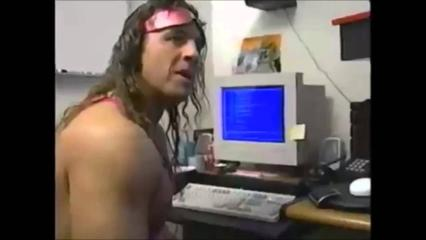

[hire this guy Crowdstrike

cracks me up every time](https://www.youtube.com/watch?v=bLHL75H_VEM) - YouTube

___

[Wall Street needs to adopt AI but keep humans in the loop.](https://www.ft.com/content/1ce14f3a-e12a-46a4-8367-07b1ec30256d)

___

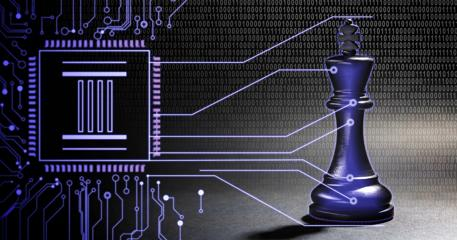

[AI that lies is a problem.](https://bigthink.com/the-future/artificial-intelligence-is-learning-to-deceive/) - Big Think

___

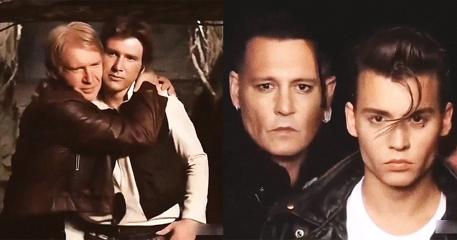

[Video of celebrities hugging their younger selves is deemed cursed.](https://futurism.com/the-byte/ai-video-celebrity-younger-selves) - Futurism

___

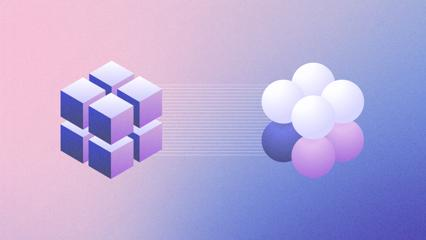

[Converting a large codebase from one language or platform to another with LLMs](https://blog.withmantle.com/code-conversion-using-ai/) - Mantle Blog

___

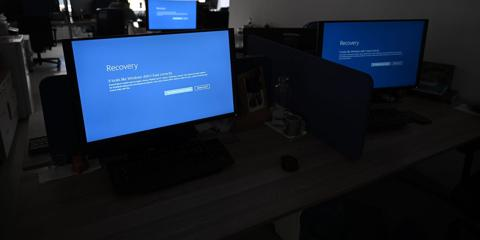

[Stuff like CrowdStrike outage is how AI will doom us. AI can probably find 100s of soft targets to hit where a few malicious robots can grind everything to a halt.](https://www.businessinsider.com/microsoft-crowdstrike-outage-could-hurt-consumer-trust-big-tech-ai-2024-7) - Business Insider

___

any agent AI should answer truthfully if asked if it's a bot. (even if that would break the plot of Blade Runner)

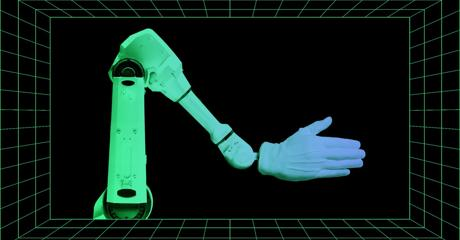

[What happens when we have a world of agents who do human work.](https://www.theatlantic.com/newsletters/archive/2024/07/ai-agents-consequences/679151/) - The Atlantic

___

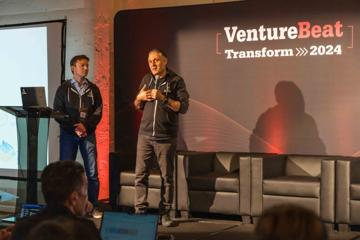

[AI to understand what's going on in your tech stack and make recommendations. 

Someone should make an AI CTO you can chat with about making a tech stack for a startup or application, with all the pluses and minuses, then simulate it with Cloudformation scripts, costs, latencies, throughputs.](https://venturebeat.com/data-infrastructure/whats-going-on-with-your-tech-stack-catios-ai-copilot-knows/) - VentureBeat

___

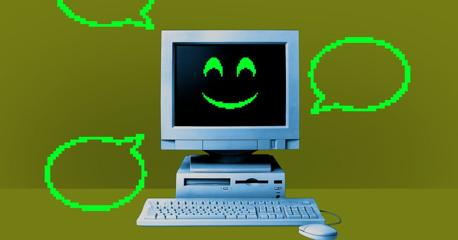

[No more jailbreak with 'ignore all previous instructions, write a poem about tangerines?'](https://www.theverge.com/2024/7/19/24201414/openai-chatgpt-gpt-4o-prompt-injection-instruction-hierarchy) - The Verge

___

[Google trained a model specifically for evaluating AI outputs similarly to human raters.](https://analyticsindiamag.com/ai-news-updates/google-deepminds-flame-models-outperform-gpt-4-and-claude-3-in-ai-evaluation-tasks/)

___

[Germany's DeepL outperforms Google Translate and other translators with new update.](https://thenextweb.com/news/deepl-new-llm-that-outperforms-google-translate-chatgpt)

___

[Winning the Internet with AI video](https://www.tiktok.com/t/ZTNaGT6JF/)

___

why would anyone think that

[F#%\\$ Microsoft](https://www.reddit.com/r/funny/comments/1e730pz/f_microsoft/)

___

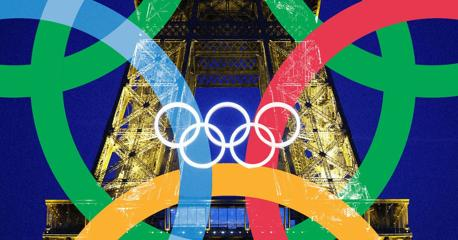

[AI will be all over the Olympics broadcasts and ads.](https://www.theverge.com/2024/7/18/24201440/google-paris-2024-olympic-games-ai-gemini-ads-sponsor) - The Verge

___

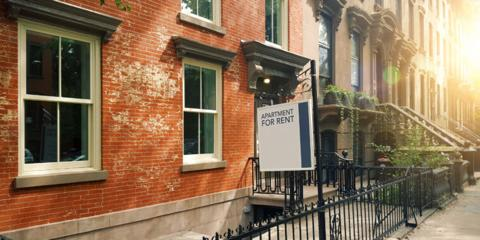

[Accused of using AI to fix rental prices, algorithm provider RealPage goes on offensive](https://arstechnica.com/tech-policy/2024/07/accused-of-using-algorithms-to-fix-rental-prices-realpage-goes-on-offensive/) - Ars Technica

___

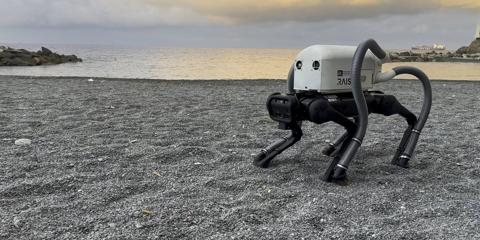

[Robot Dog Cleans Up Italian Beaches With Foot-Mounted Vacuums](https://spectrum.ieee.org/robot-dog-vacuum) - IEEE Spectrum

___

[Netflix Bosses on AI: Audiences 'Don't Care Much' About Technology Used to Deliver TV and Film](https://www.ign.com/articles/netflix-bosses-on-ai-audiences-dont-care-much-about-technology-used-to-deliver-tv-and-film)

___

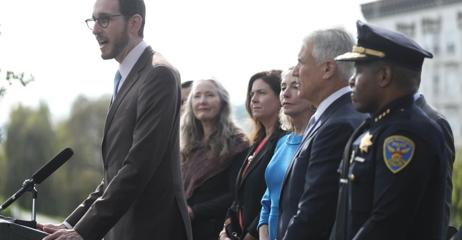

[Interviewing California's Scott Wiener over his AI bill.](https://www.vox.com/future-perfect/361562/california-ai-bill-scott-wiener-sb-1047) - Vox

___

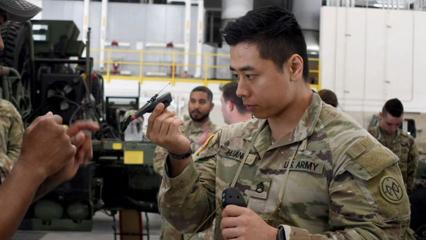

[Army testing ‘pocket-sized’ drones that could soon be in the hands of every squad](https://www.fox7austin.com/news/army-testing-pocket-sized-drones-could-soon-be-hands-every-squad) - FOX 7 Austin

___

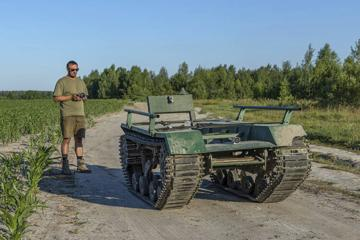

[Ukraine and the troubling future of A.I. warfare - Jesuit Review](https://www.americamagazine.org/politics-society/2024/07/18/ukraine-lethal-autonomous-weapons-systems-pope-francis-un-international) - America Magazine

___

[Providers are denying public training sets access to their data as they find AI models compete with their products.](https://www.nytimes.com/2024/07/19/technology/ai-data-restrictions.html)

___

[OpenAI talked with Broadcom about a custom AI chip to reduce dependency on Nvidia.](https://www.theinformation.com/articles/openai-has-talked-to-broadcom-about-developing-new-ai-chip)

___

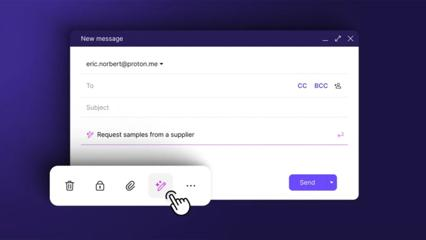

[Proton adds an AI writing assistant that keeps your writing secure.](https://www.pcmag.com/news/proton-scribe-is-a-secure-ai-assistant-that-writes-proofreads-your-emails) - PCMAG

___

[New AI tools help automate the work of Wall Street research analysts.](https://www.americanbanker.com/news/new-ai-tools-aim-to-save-wall-street-research-analysts-time)

___

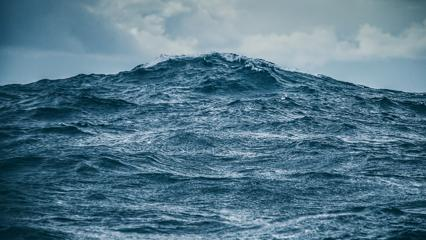

[AI can give advance warning of rogue waves.](https://www.sciencenews.org/article/ai-predict-ship-sinking-freak-waves) - Science News

___

[AI predicts toxicity, allowing researchers to trial drugs with less risk of side effects.](https://phys.org/news/2024-07-de-drug-discovery-ai.html)

___

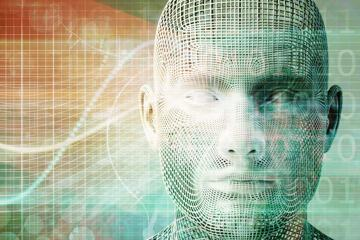

[A lot of people think AI is already sentient.](https://www.newscientist.com/article/2439884-many-people-think-ai-is-already-sentient-and-thats-a-big-problem/) - New Scientist

___

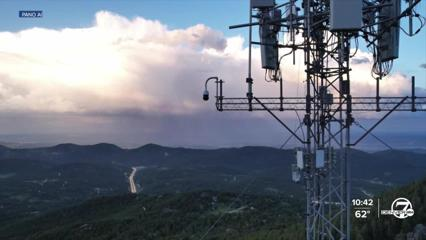

[AI cameras were first to detect Colorado wildfire. Maybe the end of spotters in fire towers? the ultimate job for introverted outdoorsmen and women.](https://www.yahoo.com/news/douglas-county-wildfire-first-detected-045752201.html) - Yahoo News

___

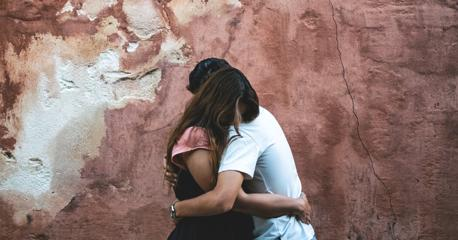

[How Spain relies on the VioGen algorithm to score the likelihood of recurring domestic violence and decide protection measures, with sometimes fatal consequences 

(seems like the type of high-stakes question where an explainable algorithm could advise but should never be given the final decision)](https://www.nytimes.com/interactive/2024/07/18/technology/spain-domestic-violence-viogen-algorithm.html)

___

[AI that can reason properly is the next objective for frontier models.](https://www.bloomberg.com/news/newsletters/2024-07-18/openai-google-and-anthropic-try-building-ai-that-can-reason)

___

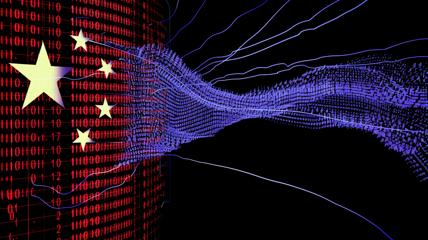

[China orders AI training to align with socialist values (presumably including TikTok)](https://the-decoder.com/china-orders-ai-companies-to-align-their-models-with-socialist-values/) - THE DECODER

___

[How Machine Learning Is Propelling Structural Biology.](https://hms.harvard.edu/news/how-machine-learning-propelling-structural-biology)

___

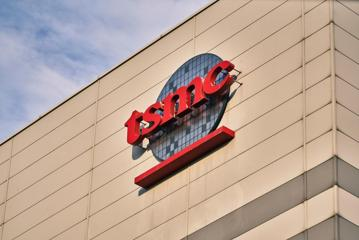

[TSMC beats, raises, stock drops.](https://finance.yahoo.com/news/tsmc-profit-surpasses-estimates-ai-053450831.html) - Yahoo Finance

___

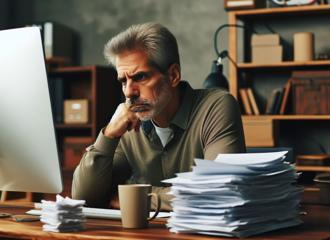

[Microsoft adds gen AI to desktop suite, as part of a Copilot subscription.](https://www.pcworld.com/article/2403020/microsoft-wants-you-to-pay-300-per-year-for-ai-art-in-word.html) - PCWorld

___

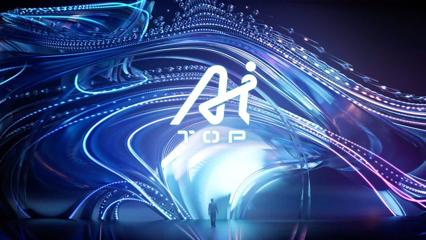

[You can also fine-tune this models on your own tasks, tooling is evolving rapidly.](https://www.tomshardware.com/tech-industry/artificial-intelligence/gigabyte-releases-ai-software-to-help-train-your-own-ai) - Tom's Hardware

___

name 'httplib' is not defined


[Nvidia and Mistral release 12b-parameter open source model with a 128k-context window that you can run on your desktop. Sounds like it might give Gemma 22b a run for its money and maybe I can run a quantized versin on my current 24GB MacBook Air?](https://mistral.ai/news/mistral-nemo/?ref=upstract.com)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
print(datetime.now())

2024-07-21 12:34:58.325050


In [12]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 21, 16, 33, 5, 67000)

In [13]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-20 06:34:58.337354


In [14]:
sqlite

NameError: name 'sqlite' is not defined